# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.ReLU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.Dropout(p = 0.01),
            nn.ReLU(),
            nn.Linear(hidden2_size, output_size)
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Dropout(p=0.01, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
#scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 800 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    #scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/800, Iteration 1/12, Loss: 1.0709
Epoch 1/800, Iteration 2/12, Loss: 0.9943
Epoch 1/800, Iteration 3/12, Loss: 0.8545
Epoch 1/800, Iteration 4/12, Loss: 0.7755
Epoch 1/800, Iteration 5/12, Loss: 0.8877
Epoch 1/800, Iteration 6/12, Loss: 0.7745
Epoch 1/800, Iteration 7/12, Loss: 0.7611
Epoch 1/800, Iteration 8/12, Loss: 0.7135
Epoch 1/800, Iteration 9/12, Loss: 0.6540
Epoch 1/800, Iteration 10/12, Loss: 0.7903
Epoch 1/800, Iteration 11/12, Loss: 0.5549
Epoch 1/800, Iteration 12/12, Loss: 0.4764
Epoch 1/800, Iteration 13/12, Loss: 0.4653
Train Error: 
 Accuracy: 47.88%, Avg loss: 0.521944, MRE: 0.479201, MAE: 0.077898 

Test Error: 
 Accuracy: 49.0%, Avg loss: 0.496931, MRE: 0.391467, MAE: 0.071723 

Epoch 2/800, Iteration 1/12, Loss: 0.4582
Epoch 2/800, Iteration 2/12, Loss: 0.4576
Epoch 2/800, Iteration 3/12, Loss: 0.4590
Epoch 2/800, Iteration 4/12, Loss: 0.3469
Epoch 2/800, Iteration 5/12, Loss: 0.4413
Epoch 2/800, Iteration 6/12, Loss: 0.4097
Epoch 2/800, Iteration 7/12, Los

Epoch 12/800, Iteration 11/12, Loss: 0.0231
Epoch 12/800, Iteration 12/12, Loss: 0.0291
Epoch 12/800, Iteration 13/12, Loss: 0.0175
Train Error: 
 Accuracy: 79.75%, Avg loss: 0.031982, MRE: 0.077992, MAE: 0.014788 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.026670, MRE: 0.075742, MAE: 0.014251 

Epoch 13/800, Iteration 1/12, Loss: 0.0253
Epoch 13/800, Iteration 2/12, Loss: 0.0315
Epoch 13/800, Iteration 3/12, Loss: 0.0333
Epoch 13/800, Iteration 4/12, Loss: 0.0265
Epoch 13/800, Iteration 5/12, Loss: 0.0453
Epoch 13/800, Iteration 6/12, Loss: 0.0646
Epoch 13/800, Iteration 7/12, Loss: 0.0305
Epoch 13/800, Iteration 8/12, Loss: 0.0171
Epoch 13/800, Iteration 9/12, Loss: 0.0202
Epoch 13/800, Iteration 10/12, Loss: 0.0284
Epoch 13/800, Iteration 11/12, Loss: 0.0496
Epoch 13/800, Iteration 12/12, Loss: 0.0125
Epoch 13/800, Iteration 13/12, Loss: 0.0172
Train Error: 
 Accuracy: 82.62%, Avg loss: 0.029204, MRE: 0.074757, MAE: 0.014097 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.025621, MRE:

Train Error: 
 Accuracy: 89.75%, Avg loss: 0.018717, MRE: 0.060790, MAE: 0.010620 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.016143, MRE: 0.055004, MAE: 0.011212 

Epoch 25/800, Iteration 1/12, Loss: 0.0255
Epoch 25/800, Iteration 2/12, Loss: 0.0246
Epoch 25/800, Iteration 3/12, Loss: 0.0295
Epoch 25/800, Iteration 4/12, Loss: 0.0233
Epoch 25/800, Iteration 5/12, Loss: 0.0135
Epoch 25/800, Iteration 6/12, Loss: 0.0147
Epoch 25/800, Iteration 7/12, Loss: 0.0143
Epoch 25/800, Iteration 8/12, Loss: 0.0162
Epoch 25/800, Iteration 9/12, Loss: 0.0159
Epoch 25/800, Iteration 10/12, Loss: 0.0106
Epoch 25/800, Iteration 11/12, Loss: 0.0259
Epoch 25/800, Iteration 12/12, Loss: 0.0135
Epoch 25/800, Iteration 13/12, Loss: 0.0435
Train Error: 
 Accuracy: 93.62%, Avg loss: 0.018798, MRE: 0.070780, MAE: 0.010799 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.019045, MRE: 0.055090, MAE: 0.011763 

Epoch 26/800, Iteration 1/12, Loss: 0.0178
Epoch 26/800, Iteration 2/12, Loss: 0.0152
Epoch 26/800, Itera

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.015602, MRE: 0.055347, MAE: 0.009419 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.015195, MRE: 0.048797, MAE: 0.010470 

Epoch 37/800, Iteration 1/12, Loss: 0.0134
Epoch 37/800, Iteration 2/12, Loss: 0.0415
Epoch 37/800, Iteration 3/12, Loss: 0.0121
Epoch 37/800, Iteration 4/12, Loss: 0.0110
Epoch 37/800, Iteration 5/12, Loss: 0.0365
Epoch 37/800, Iteration 6/12, Loss: 0.0084
Epoch 37/800, Iteration 7/12, Loss: 0.0140
Epoch 37/800, Iteration 8/12, Loss: 0.0218
Epoch 37/800, Iteration 9/12, Loss: 0.0078
Epoch 37/800, Iteration 10/12, Loss: 0.0078
Epoch 37/800, Iteration 11/12, Loss: 0.0136
Epoch 37/800, Iteration 12/12, Loss: 0.0095
Epoch 37/800, Iteration 13/12, Loss: 0.0118
Train Error: 
 Accuracy: 92.12%, Avg loss: 0.014238, MRE: 0.053239, MAE: 0.008938 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.013136, MRE: 0.047280, MAE: 0.009894 

Epoch 38/800, Iteration 1/12, Loss: 0.0196
Epoch 38/800, Iteration 2/12, Loss: 0.0139
Epoch 38/800, Itera

Train Error: 
 Accuracy: 92.38%, Avg loss: 0.012726, MRE: 0.048582, MAE: 0.008299 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.010975, MRE: 0.043170, MAE: 0.008951 

Epoch 49/800, Iteration 1/12, Loss: 0.0056
Epoch 49/800, Iteration 2/12, Loss: 0.0096
Epoch 49/800, Iteration 3/12, Loss: 0.0065
Epoch 49/800, Iteration 4/12, Loss: 0.0180
Epoch 49/800, Iteration 5/12, Loss: 0.0107
Epoch 49/800, Iteration 6/12, Loss: 0.0091
Epoch 49/800, Iteration 7/12, Loss: 0.0098
Epoch 49/800, Iteration 8/12, Loss: 0.0204
Epoch 49/800, Iteration 9/12, Loss: 0.0135
Epoch 49/800, Iteration 10/12, Loss: 0.0253
Epoch 49/800, Iteration 11/12, Loss: 0.0141
Epoch 49/800, Iteration 12/12, Loss: 0.0271
Epoch 49/800, Iteration 13/12, Loss: 0.0113
Train Error: 
 Accuracy: 91.62%, Avg loss: 0.012192, MRE: 0.046643, MAE: 0.008209 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.010684, MRE: 0.042950, MAE: 0.008915 

Epoch 50/800, Iteration 1/12, Loss: 0.0139
Epoch 50/800, Iteration 2/12, Loss: 0.0189
Epoch 50/800, Itera

Train Error: 
 Accuracy: 93.5%, Avg loss: 0.011124, MRE: 0.044825, MAE: 0.007658 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.009589, MRE: 0.039082, MAE: 0.008155 

Epoch 61/800, Iteration 1/12, Loss: 0.0111
Epoch 61/800, Iteration 2/12, Loss: 0.0053
Epoch 61/800, Iteration 3/12, Loss: 0.0119
Epoch 61/800, Iteration 4/12, Loss: 0.0217
Epoch 61/800, Iteration 5/12, Loss: 0.0148
Epoch 61/800, Iteration 6/12, Loss: 0.0170
Epoch 61/800, Iteration 7/12, Loss: 0.0095
Epoch 61/800, Iteration 8/12, Loss: 0.0107
Epoch 61/800, Iteration 9/12, Loss: 0.0303
Epoch 61/800, Iteration 10/12, Loss: 0.0070
Epoch 61/800, Iteration 11/12, Loss: 0.0080
Epoch 61/800, Iteration 12/12, Loss: 0.0062
Epoch 61/800, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 92.88%, Avg loss: 0.011011, MRE: 0.043190, MAE: 0.007573 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.009386, MRE: 0.039301, MAE: 0.008164 

Epoch 62/800, Iteration 1/12, Loss: 0.0192
Epoch 62/800, Iteration 2/12, Loss: 0.0090
Epoch 62/800, Iterat

Train Error: 
 Accuracy: 91.88%, Avg loss: 0.010150, MRE: 0.041684, MAE: 0.007226 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.008144, MRE: 0.037644, MAE: 0.007663 

Epoch 73/800, Iteration 1/12, Loss: 0.0159
Epoch 73/800, Iteration 2/12, Loss: 0.0048
Epoch 73/800, Iteration 3/12, Loss: 0.0066
Epoch 73/800, Iteration 4/12, Loss: 0.0144
Epoch 73/800, Iteration 5/12, Loss: 0.0117
Epoch 73/800, Iteration 6/12, Loss: 0.0096
Epoch 73/800, Iteration 7/12, Loss: 0.0076
Epoch 73/800, Iteration 8/12, Loss: 0.0078
Epoch 73/800, Iteration 9/12, Loss: 0.0110
Epoch 73/800, Iteration 10/12, Loss: 0.0299
Epoch 73/800, Iteration 11/12, Loss: 0.0099
Epoch 73/800, Iteration 12/12, Loss: 0.0052
Epoch 73/800, Iteration 13/12, Loss: 0.0055
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.009661, MRE: 0.040207, MAE: 0.007133 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.008687, MRE: 0.037090, MAE: 0.007698 

Epoch 74/800, Iteration 1/12, Loss: 0.0038
Epoch 74/800, Iteration 2/12, Loss: 0.0149
Epoch 74/800, Itera

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.009141, MRE: 0.038706, MAE: 0.006861 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.007360, MRE: 0.035259, MAE: 0.007187 

Epoch 85/800, Iteration 1/12, Loss: 0.0096
Epoch 85/800, Iteration 2/12, Loss: 0.0207
Epoch 85/800, Iteration 3/12, Loss: 0.0043
Epoch 85/800, Iteration 4/12, Loss: 0.0059
Epoch 85/800, Iteration 5/12, Loss: 0.0089
Epoch 85/800, Iteration 6/12, Loss: 0.0101
Epoch 85/800, Iteration 7/12, Loss: 0.0059
Epoch 85/800, Iteration 8/12, Loss: 0.0125
Epoch 85/800, Iteration 9/12, Loss: 0.0049
Epoch 85/800, Iteration 10/12, Loss: 0.0111
Epoch 85/800, Iteration 11/12, Loss: 0.0142
Epoch 85/800, Iteration 12/12, Loss: 0.0083
Epoch 85/800, Iteration 13/12, Loss: 0.0175
Train Error: 
 Accuracy: 93.5%, Avg loss: 0.008973, MRE: 0.037419, MAE: 0.006798 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.007959, MRE: 0.035813, MAE: 0.007388 

Epoch 86/800, Iteration 1/12, Loss: 0.0063
Epoch 86/800, Iteration 2/12, Loss: 0.0174
Epoch 86/800, Iterati

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.008301, MRE: 0.035984, MAE: 0.006509 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.007520, MRE: 0.033767, MAE: 0.007012 

Epoch 97/800, Iteration 1/12, Loss: 0.0148
Epoch 97/800, Iteration 2/12, Loss: 0.0174
Epoch 97/800, Iteration 3/12, Loss: 0.0062
Epoch 97/800, Iteration 4/12, Loss: 0.0061
Epoch 97/800, Iteration 5/12, Loss: 0.0056
Epoch 97/800, Iteration 6/12, Loss: 0.0176
Epoch 97/800, Iteration 7/12, Loss: 0.0054
Epoch 97/800, Iteration 8/12, Loss: 0.0053
Epoch 97/800, Iteration 9/12, Loss: 0.0052
Epoch 97/800, Iteration 10/12, Loss: 0.0052
Epoch 97/800, Iteration 11/12, Loss: 0.0086
Epoch 97/800, Iteration 12/12, Loss: 0.0089
Epoch 97/800, Iteration 13/12, Loss: 0.0281
Train Error: 
 Accuracy: 93.5%, Avg loss: 0.008253, MRE: 0.035989, MAE: 0.006442 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006665, MRE: 0.033593, MAE: 0.006782 

Epoch 98/800, Iteration 1/12, Loss: 0.0052
Epoch 98/800, Iteration 2/12, Loss: 0.0106
Epoch 98/800, Iterati

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.008083, MRE: 0.035725, MAE: 0.006260 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.006934, MRE: 0.032528, MAE: 0.006647 

Epoch 109/800, Iteration 1/12, Loss: 0.0057
Epoch 109/800, Iteration 2/12, Loss: 0.0097
Epoch 109/800, Iteration 3/12, Loss: 0.0095
Epoch 109/800, Iteration 4/12, Loss: 0.0110
Epoch 109/800, Iteration 5/12, Loss: 0.0034
Epoch 109/800, Iteration 6/12, Loss: 0.0103
Epoch 109/800, Iteration 7/12, Loss: 0.0039
Epoch 109/800, Iteration 8/12, Loss: 0.0105
Epoch 109/800, Iteration 9/12, Loss: 0.0044
Epoch 109/800, Iteration 10/12, Loss: 0.0096
Epoch 109/800, Iteration 11/12, Loss: 0.0078
Epoch 109/800, Iteration 12/12, Loss: 0.0164
Epoch 109/800, Iteration 13/12, Loss: 0.0397
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.008885, MRE: 0.039695, MAE: 0.007073 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.009976, MRE: 0.036506, MAE: 0.007786 

Epoch 110/800, Iteration 1/12, Loss: 0.0183
Epoch 110/800, Iteration 2/12, Loss: 0.0084
Epoch

Epoch 120/800, Iteration 12/12, Loss: 0.0194
Epoch 120/800, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.007103, MRE: 0.033419, MAE: 0.005972 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.006409, MRE: 0.031796, MAE: 0.006494 

Epoch 121/800, Iteration 1/12, Loss: 0.0073
Epoch 121/800, Iteration 2/12, Loss: 0.0062
Epoch 121/800, Iteration 3/12, Loss: 0.0039
Epoch 121/800, Iteration 4/12, Loss: 0.0076
Epoch 121/800, Iteration 5/12, Loss: 0.0081
Epoch 121/800, Iteration 6/12, Loss: 0.0087
Epoch 121/800, Iteration 7/12, Loss: 0.0187
Epoch 121/800, Iteration 8/12, Loss: 0.0053
Epoch 121/800, Iteration 9/12, Loss: 0.0065
Epoch 121/800, Iteration 10/12, Loss: 0.0093
Epoch 121/800, Iteration 11/12, Loss: 0.0123
Epoch 121/800, Iteration 12/12, Loss: 0.0064
Epoch 121/800, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.007113, MRE: 0.034044, MAE: 0.006030 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005986, MRE: 0.033129, MAE: 0.006565 

Epo

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.006610, MRE: 0.033145, MAE: 0.005749 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.006120, MRE: 0.030693, MAE: 0.006159 

Epoch 132/800, Iteration 1/12, Loss: 0.0123
Epoch 132/800, Iteration 2/12, Loss: 0.0100
Epoch 132/800, Iteration 3/12, Loss: 0.0038
Epoch 132/800, Iteration 4/12, Loss: 0.0046
Epoch 132/800, Iteration 5/12, Loss: 0.0039
Epoch 132/800, Iteration 6/12, Loss: 0.0093
Epoch 132/800, Iteration 7/12, Loss: 0.0149
Epoch 132/800, Iteration 8/12, Loss: 0.0049
Epoch 132/800, Iteration 9/12, Loss: 0.0074
Epoch 132/800, Iteration 10/12, Loss: 0.0057
Epoch 132/800, Iteration 11/12, Loss: 0.0122
Epoch 132/800, Iteration 12/12, Loss: 0.0034
Epoch 132/800, Iteration 13/12, Loss: 0.0128
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.006918, MRE: 0.033350, MAE: 0.005963 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.007080, MRE: 0.031755, MAE: 0.006476 

Epoch 133/800, Iteration 1/12, Loss: 0.0066
Epoch 133/800, Iteration 2/12, Loss: 0.0045
Epoch

Train Error: 
 Accuracy: 95.62%, Avg loss: 0.006252, MRE: 0.032381, MAE: 0.005574 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.005750, MRE: 0.029615, MAE: 0.006020 

Epoch 144/800, Iteration 1/12, Loss: 0.0054
Epoch 144/800, Iteration 2/12, Loss: 0.0141
Epoch 144/800, Iteration 3/12, Loss: 0.0048
Epoch 144/800, Iteration 4/12, Loss: 0.0078
Epoch 144/800, Iteration 5/12, Loss: 0.0036
Epoch 144/800, Iteration 6/12, Loss: 0.0077
Epoch 144/800, Iteration 7/12, Loss: 0.0047
Epoch 144/800, Iteration 8/12, Loss: 0.0054
Epoch 144/800, Iteration 9/12, Loss: 0.0034
Epoch 144/800, Iteration 10/12, Loss: 0.0122
Epoch 144/800, Iteration 11/12, Loss: 0.0128
Epoch 144/800, Iteration 12/12, Loss: 0.0056
Epoch 144/800, Iteration 13/12, Loss: 0.0095
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.006191, MRE: 0.031667, MAE: 0.005565 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005728, MRE: 0.030645, MAE: 0.006105 

Epoch 145/800, Iteration 1/12, Loss: 0.0143
Epoch 145/800, Iteration 2/12, Loss: 0.0074
Epoc

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.006083, MRE: 0.030753, MAE: 0.005484 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005148, MRE: 0.029176, MAE: 0.005853 

Epoch 156/800, Iteration 1/12, Loss: 0.0078
Epoch 156/800, Iteration 2/12, Loss: 0.0129
Epoch 156/800, Iteration 3/12, Loss: 0.0049
Epoch 156/800, Iteration 4/12, Loss: 0.0126
Epoch 156/800, Iteration 5/12, Loss: 0.0109
Epoch 156/800, Iteration 6/12, Loss: 0.0048
Epoch 156/800, Iteration 7/12, Loss: 0.0037
Epoch 156/800, Iteration 8/12, Loss: 0.0054
Epoch 156/800, Iteration 9/12, Loss: 0.0043
Epoch 156/800, Iteration 10/12, Loss: 0.0059
Epoch 156/800, Iteration 11/12, Loss: 0.0040
Epoch 156/800, Iteration 12/12, Loss: 0.0064
Epoch 156/800, Iteration 13/12, Loss: 0.0083
Train Error: 
 Accuracy: 95.75%, Avg loss: 0.006258, MRE: 0.031236, MAE: 0.005450 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.005382, MRE: 0.028680, MAE: 0.005810 

Epoch 157/800, Iteration 1/12, Loss: 0.0096
Epoch 157/800, Iteration 2/12, Loss: 0.0044
Epoc

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.005805, MRE: 0.030204, MAE: 0.005262 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.004608, MRE: 0.029074, MAE: 0.005558 

Epoch 168/800, Iteration 1/12, Loss: 0.0070
Epoch 168/800, Iteration 2/12, Loss: 0.0029
Epoch 168/800, Iteration 3/12, Loss: 0.0048
Epoch 168/800, Iteration 4/12, Loss: 0.0036
Epoch 168/800, Iteration 5/12, Loss: 0.0032
Epoch 168/800, Iteration 6/12, Loss: 0.0087
Epoch 168/800, Iteration 7/12, Loss: 0.0042
Epoch 168/800, Iteration 8/12, Loss: 0.0130
Epoch 168/800, Iteration 9/12, Loss: 0.0075
Epoch 168/800, Iteration 10/12, Loss: 0.0078
Epoch 168/800, Iteration 11/12, Loss: 0.0104
Epoch 168/800, Iteration 12/12, Loss: 0.0081
Epoch 168/800, Iteration 13/12, Loss: 0.0135
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.005520, MRE: 0.029982, MAE: 0.005229 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.004891, MRE: 0.028523, MAE: 0.005623 

Epoch 169/800, Iteration 1/12, Loss: 0.0048
Epoch 169/800, Iteration 2/12, Loss: 0.0048
Epoch

Train Error: 
 Accuracy: 94.38%, Avg loss: 0.005319, MRE: 0.029569, MAE: 0.005121 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.004522, MRE: 0.028400, MAE: 0.005549 

Epoch 180/800, Iteration 1/12, Loss: 0.0144
Epoch 180/800, Iteration 2/12, Loss: 0.0091
Epoch 180/800, Iteration 3/12, Loss: 0.0069
Epoch 180/800, Iteration 4/12, Loss: 0.0061
Epoch 180/800, Iteration 5/12, Loss: 0.0077
Epoch 180/800, Iteration 6/12, Loss: 0.0026
Epoch 180/800, Iteration 7/12, Loss: 0.0041
Epoch 180/800, Iteration 8/12, Loss: 0.0046
Epoch 180/800, Iteration 9/12, Loss: 0.0117
Epoch 180/800, Iteration 10/12, Loss: 0.0034
Epoch 180/800, Iteration 11/12, Loss: 0.0048
Epoch 180/800, Iteration 12/12, Loss: 0.0047
Epoch 180/800, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.005676, MRE: 0.030410, MAE: 0.005196 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004664, MRE: 0.027201, MAE: 0.005511 

Epoch 181/800, Iteration 1/12, Loss: 0.0055
Epoch 181/800, Iteration 2/12, Loss: 0.0044
Epoch

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.005080, MRE: 0.029538, MAE: 0.004941 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.004244, MRE: 0.027074, MAE: 0.005190 

Epoch 192/800, Iteration 1/12, Loss: 0.0042
Epoch 192/800, Iteration 2/12, Loss: 0.0047
Epoch 192/800, Iteration 3/12, Loss: 0.0112
Epoch 192/800, Iteration 4/12, Loss: 0.0029
Epoch 192/800, Iteration 5/12, Loss: 0.0057
Epoch 192/800, Iteration 6/12, Loss: 0.0047
Epoch 192/800, Iteration 7/12, Loss: 0.0066
Epoch 192/800, Iteration 8/12, Loss: 0.0044
Epoch 192/800, Iteration 9/12, Loss: 0.0085
Epoch 192/800, Iteration 10/12, Loss: 0.0056
Epoch 192/800, Iteration 11/12, Loss: 0.0040
Epoch 192/800, Iteration 12/12, Loss: 0.0108
Epoch 192/800, Iteration 13/12, Loss: 0.0054
Train Error: 
 Accuracy: 95.75%, Avg loss: 0.004954, MRE: 0.028725, MAE: 0.004916 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.004417, MRE: 0.027010, MAE: 0.005321 

Epoch 193/800, Iteration 1/12, Loss: 0.0094
Epoch 193/800, Iteration 2/12, Loss: 0.0049
Epoch

Train Error: 
 Accuracy: 94.88%, Avg loss: 0.004858, MRE: 0.028958, MAE: 0.004860 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.004034, MRE: 0.026865, MAE: 0.005169 

Epoch 204/800, Iteration 1/12, Loss: 0.0044
Epoch 204/800, Iteration 2/12, Loss: 0.0058
Epoch 204/800, Iteration 3/12, Loss: 0.0037
Epoch 204/800, Iteration 4/12, Loss: 0.0069
Epoch 204/800, Iteration 5/12, Loss: 0.0026
Epoch 204/800, Iteration 6/12, Loss: 0.0037
Epoch 204/800, Iteration 7/12, Loss: 0.0050
Epoch 204/800, Iteration 8/12, Loss: 0.0057
Epoch 204/800, Iteration 9/12, Loss: 0.0116
Epoch 204/800, Iteration 10/12, Loss: 0.0037
Epoch 204/800, Iteration 11/12, Loss: 0.0105
Epoch 204/800, Iteration 12/12, Loss: 0.0072
Epoch 204/800, Iteration 13/12, Loss: 0.0106
Train Error: 
 Accuracy: 95.75%, Avg loss: 0.004818, MRE: 0.032168, MAE: 0.004899 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.004116, MRE: 0.026352, MAE: 0.005218 

Epoch 205/800, Iteration 1/12, Loss: 0.0055
Epoch 205/800, Iteration 2/12, Loss: 0.0072
Epoc

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004649, MRE: 0.028146, MAE: 0.004785 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004269, MRE: 0.026171, MAE: 0.005160 

Epoch 216/800, Iteration 1/12, Loss: 0.0023
Epoch 216/800, Iteration 2/12, Loss: 0.0051
Epoch 216/800, Iteration 3/12, Loss: 0.0060
Epoch 216/800, Iteration 4/12, Loss: 0.0060
Epoch 216/800, Iteration 5/12, Loss: 0.0133
Epoch 216/800, Iteration 6/12, Loss: 0.0043
Epoch 216/800, Iteration 7/12, Loss: 0.0085
Epoch 216/800, Iteration 8/12, Loss: 0.0029
Epoch 216/800, Iteration 9/12, Loss: 0.0062
Epoch 216/800, Iteration 10/12, Loss: 0.0087
Epoch 216/800, Iteration 11/12, Loss: 0.0030
Epoch 216/800, Iteration 12/12, Loss: 0.0050
Epoch 216/800, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.004644, MRE: 0.029059, MAE: 0.004764 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.004176, MRE: 0.025449, MAE: 0.005102 

Epoch 217/800, Iteration 1/12, Loss: 0.0052
Epoch 217/800, Iteration 2/12, Loss: 0.0021
Epoc

Train Error: 
 Accuracy: 95.62%, Avg loss: 0.004540, MRE: 0.027775, MAE: 0.004740 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.003915, MRE: 0.026547, MAE: 0.005164 

Epoch 228/800, Iteration 1/12, Loss: 0.0054
Epoch 228/800, Iteration 2/12, Loss: 0.0051
Epoch 228/800, Iteration 3/12, Loss: 0.0090
Epoch 228/800, Iteration 4/12, Loss: 0.0038
Epoch 228/800, Iteration 5/12, Loss: 0.0075
Epoch 228/800, Iteration 6/12, Loss: 0.0032
Epoch 228/800, Iteration 7/12, Loss: 0.0028
Epoch 228/800, Iteration 8/12, Loss: 0.0067
Epoch 228/800, Iteration 9/12, Loss: 0.0028
Epoch 228/800, Iteration 10/12, Loss: 0.0046
Epoch 228/800, Iteration 11/12, Loss: 0.0128
Epoch 228/800, Iteration 12/12, Loss: 0.0050
Epoch 228/800, Iteration 13/12, Loss: 0.0070
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004458, MRE: 0.027117, MAE: 0.004639 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004074, MRE: 0.025883, MAE: 0.005043 

Epoch 229/800, Iteration 1/12, Loss: 0.0048
Epoch 229/800, Iteration 2/12, Loss: 0.0057
Epoc

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.004215, MRE: 0.027356, MAE: 0.004510 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.003885, MRE: 0.025513, MAE: 0.004928 

Epoch 240/800, Iteration 1/12, Loss: 0.0061
Epoch 240/800, Iteration 2/12, Loss: 0.0050
Epoch 240/800, Iteration 3/12, Loss: 0.0027
Epoch 240/800, Iteration 4/12, Loss: 0.0037
Epoch 240/800, Iteration 5/12, Loss: 0.0044
Epoch 240/800, Iteration 6/12, Loss: 0.0041
Epoch 240/800, Iteration 7/12, Loss: 0.0040
Epoch 240/800, Iteration 8/12, Loss: 0.0047
Epoch 240/800, Iteration 9/12, Loss: 0.0043
Epoch 240/800, Iteration 10/12, Loss: 0.0135
Epoch 240/800, Iteration 11/12, Loss: 0.0044
Epoch 240/800, Iteration 12/12, Loss: 0.0048
Epoch 240/800, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.004199, MRE: 0.027402, MAE: 0.004485 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.003881, MRE: 0.024793, MAE: 0.004840 

Epoch 241/800, Iteration 1/12, Loss: 0.0056
Epoch 241/800, Iteration 2/12, Loss: 0.0090
Epoch 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.004086, MRE: 0.027380, MAE: 0.004509 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003930, MRE: 0.025290, MAE: 0.004896 

Epoch 252/800, Iteration 1/12, Loss: 0.0036
Epoch 252/800, Iteration 2/12, Loss: 0.0031
Epoch 252/800, Iteration 3/12, Loss: 0.0067
Epoch 252/800, Iteration 4/12, Loss: 0.0080
Epoch 252/800, Iteration 5/12, Loss: 0.0049
Epoch 252/800, Iteration 6/12, Loss: 0.0037
Epoch 252/800, Iteration 7/12, Loss: 0.0058
Epoch 252/800, Iteration 8/12, Loss: 0.0055
Epoch 252/800, Iteration 9/12, Loss: 0.0047
Epoch 252/800, Iteration 10/12, Loss: 0.0029
Epoch 252/800, Iteration 11/12, Loss: 0.0070
Epoch 252/800, Iteration 12/12, Loss: 0.0070
Epoch 252/800, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.004136, MRE: 0.027980, MAE: 0.004521 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.003621, MRE: 0.025422, MAE: 0.004926 

Epoch 253/800, Iteration 1/12, Loss: 0.0176
Epoch 253/800, Iteration 2/12, Loss: 0.0039
Epoch

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.003908, MRE: 0.026556, MAE: 0.004370 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.003705, MRE: 0.024032, MAE: 0.004675 

Epoch 264/800, Iteration 1/12, Loss: 0.0101
Epoch 264/800, Iteration 2/12, Loss: 0.0031
Epoch 264/800, Iteration 3/12, Loss: 0.0028
Epoch 264/800, Iteration 4/12, Loss: 0.0029
Epoch 264/800, Iteration 5/12, Loss: 0.0039
Epoch 264/800, Iteration 6/12, Loss: 0.0067
Epoch 264/800, Iteration 7/12, Loss: 0.0067
Epoch 264/800, Iteration 8/12, Loss: 0.0027
Epoch 264/800, Iteration 9/12, Loss: 0.0040
Epoch 264/800, Iteration 10/12, Loss: 0.0071
Epoch 264/800, Iteration 11/12, Loss: 0.0068
Epoch 264/800, Iteration 12/12, Loss: 0.0077
Epoch 264/800, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.003928, MRE: 0.026371, MAE: 0.004373 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.003772, MRE: 0.024254, MAE: 0.004767 

Epoch 265/800, Iteration 1/12, Loss: 0.0034
Epoch 265/800, Iteration 2/12, Loss: 0.0054
Epoch

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.003744, MRE: 0.026352, MAE: 0.004247 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.003442, MRE: 0.023735, MAE: 0.004632 

Epoch 276/800, Iteration 1/12, Loss: 0.0075
Epoch 276/800, Iteration 2/12, Loss: 0.0024
Epoch 276/800, Iteration 3/12, Loss: 0.0098
Epoch 276/800, Iteration 4/12, Loss: 0.0034
Epoch 276/800, Iteration 5/12, Loss: 0.0070
Epoch 276/800, Iteration 6/12, Loss: 0.0066
Epoch 276/800, Iteration 7/12, Loss: 0.0035
Epoch 276/800, Iteration 8/12, Loss: 0.0043
Epoch 276/800, Iteration 9/12, Loss: 0.0075
Epoch 276/800, Iteration 10/12, Loss: 0.0021
Epoch 276/800, Iteration 11/12, Loss: 0.0032
Epoch 276/800, Iteration 12/12, Loss: 0.0040
Epoch 276/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.003920, MRE: 0.026633, MAE: 0.004320 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.003348, MRE: 0.024097, MAE: 0.004668 

Epoch 277/800, Iteration 1/12, Loss: 0.0030
Epoch 277/800, Iteration 2/12, Loss: 0.0086
Epoc

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.003685, MRE: 0.026001, MAE: 0.004224 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.003325, MRE: 0.023808, MAE: 0.004642 

Epoch 288/800, Iteration 1/12, Loss: 0.0038
Epoch 288/800, Iteration 2/12, Loss: 0.0067
Epoch 288/800, Iteration 3/12, Loss: 0.0085
Epoch 288/800, Iteration 4/12, Loss: 0.0107
Epoch 288/800, Iteration 5/12, Loss: 0.0063
Epoch 288/800, Iteration 6/12, Loss: 0.0055
Epoch 288/800, Iteration 7/12, Loss: 0.0061
Epoch 288/800, Iteration 8/12, Loss: 0.0031
Epoch 288/800, Iteration 9/12, Loss: 0.0032
Epoch 288/800, Iteration 10/12, Loss: 0.0021
Epoch 288/800, Iteration 11/12, Loss: 0.0060
Epoch 288/800, Iteration 12/12, Loss: 0.0025
Epoch 288/800, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.003883, MRE: 0.026627, MAE: 0.004267 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.003246, MRE: 0.023756, MAE: 0.004558 

Epoch 289/800, Iteration 1/12, Loss: 0.0029
Epoch 289/800, Iteration 2/12, Loss: 0.0131
Epoc

Train Error: 
 Accuracy: 95.75%, Avg loss: 0.003716, MRE: 0.026024, MAE: 0.004230 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.003266, MRE: 0.024525, MAE: 0.004635 

Epoch 300/800, Iteration 1/12, Loss: 0.0054
Epoch 300/800, Iteration 2/12, Loss: 0.0133
Epoch 300/800, Iteration 3/12, Loss: 0.0042
Epoch 300/800, Iteration 4/12, Loss: 0.0041
Epoch 300/800, Iteration 5/12, Loss: 0.0069
Epoch 300/800, Iteration 6/12, Loss: 0.0037
Epoch 300/800, Iteration 7/12, Loss: 0.0033
Epoch 300/800, Iteration 8/12, Loss: 0.0056
Epoch 300/800, Iteration 9/12, Loss: 0.0041
Epoch 300/800, Iteration 10/12, Loss: 0.0031
Epoch 300/800, Iteration 11/12, Loss: 0.0024
Epoch 300/800, Iteration 12/12, Loss: 0.0033
Epoch 300/800, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.003567, MRE: 0.025450, MAE: 0.004148 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.003276, MRE: 0.023827, MAE: 0.004601 

Epoch 301/800, Iteration 1/12, Loss: 0.0042
Epoch 301/800, Iteration 2/12, Loss: 0.0047
Epoc

Train Error: 
 Accuracy: 97.62%, Avg loss: 0.003585, MRE: 0.026156, MAE: 0.004190 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003731, MRE: 0.023117, MAE: 0.004584 

Epoch 312/800, Iteration 1/12, Loss: 0.0086
Epoch 312/800, Iteration 2/12, Loss: 0.0060
Epoch 312/800, Iteration 3/12, Loss: 0.0048
Epoch 312/800, Iteration 4/12, Loss: 0.0029
Epoch 312/800, Iteration 5/12, Loss: 0.0030
Epoch 312/800, Iteration 6/12, Loss: 0.0027
Epoch 312/800, Iteration 7/12, Loss: 0.0041
Epoch 312/800, Iteration 8/12, Loss: 0.0056
Epoch 312/800, Iteration 9/12, Loss: 0.0053
Epoch 312/800, Iteration 10/12, Loss: 0.0036
Epoch 312/800, Iteration 11/12, Loss: 0.0023
Epoch 312/800, Iteration 12/12, Loss: 0.0041
Epoch 312/800, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.003512, MRE: 0.026681, MAE: 0.004142 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003449, MRE: 0.022644, MAE: 0.004485 

Epoch 313/800, Iteration 1/12, Loss: 0.0111
Epoch 313/800, Iteration 2/12, Loss: 0.0033
Epoc

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.003686, MRE: 0.025289, MAE: 0.004116 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.003296, MRE: 0.023484, MAE: 0.004556 

Epoch 324/800, Iteration 1/12, Loss: 0.0079
Epoch 324/800, Iteration 2/12, Loss: 0.0036
Epoch 324/800, Iteration 3/12, Loss: 0.0032
Epoch 324/800, Iteration 4/12, Loss: 0.0024
Epoch 324/800, Iteration 5/12, Loss: 0.0059
Epoch 324/800, Iteration 6/12, Loss: 0.0083
Epoch 324/800, Iteration 7/12, Loss: 0.0026
Epoch 324/800, Iteration 8/12, Loss: 0.0037
Epoch 324/800, Iteration 9/12, Loss: 0.0049
Epoch 324/800, Iteration 10/12, Loss: 0.0028
Epoch 324/800, Iteration 11/12, Loss: 0.0034
Epoch 324/800, Iteration 12/12, Loss: 0.0064
Epoch 324/800, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.003389, MRE: 0.026096, MAE: 0.004087 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003357, MRE: 0.022647, MAE: 0.004437 

Epoch 325/800, Iteration 1/12, Loss: 0.0079
Epoch 325/800, Iteration 2/12, Loss: 0.0073
Epoch

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.003203, MRE: 0.024548, MAE: 0.004003 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.003291, MRE: 0.023543, MAE: 0.004596 

Epoch 336/800, Iteration 1/12, Loss: 0.0028
Epoch 336/800, Iteration 2/12, Loss: 0.0041
Epoch 336/800, Iteration 3/12, Loss: 0.0057
Epoch 336/800, Iteration 4/12, Loss: 0.0067
Epoch 336/800, Iteration 5/12, Loss: 0.0074
Epoch 336/800, Iteration 6/12, Loss: 0.0018
Epoch 336/800, Iteration 7/12, Loss: 0.0039
Epoch 336/800, Iteration 8/12, Loss: 0.0046
Epoch 336/800, Iteration 9/12, Loss: 0.0047
Epoch 336/800, Iteration 10/12, Loss: 0.0031
Epoch 336/800, Iteration 11/12, Loss: 0.0027
Epoch 336/800, Iteration 12/12, Loss: 0.0062
Epoch 336/800, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.003430, MRE: 0.025115, MAE: 0.004129 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.003236, MRE: 0.024464, MAE: 0.004697 

Epoch 337/800, Iteration 1/12, Loss: 0.0032
Epoch 337/800, Iteration 2/12, Loss: 0.0062
Epoch

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.003173, MRE: 0.025143, MAE: 0.003918 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002968, MRE: 0.022082, MAE: 0.004307 

Epoch 348/800, Iteration 1/12, Loss: 0.0034
Epoch 348/800, Iteration 2/12, Loss: 0.0077
Epoch 348/800, Iteration 3/12, Loss: 0.0021
Epoch 348/800, Iteration 4/12, Loss: 0.0070
Epoch 348/800, Iteration 5/12, Loss: 0.0030
Epoch 348/800, Iteration 6/12, Loss: 0.0072
Epoch 348/800, Iteration 7/12, Loss: 0.0033
Epoch 348/800, Iteration 8/12, Loss: 0.0033
Epoch 348/800, Iteration 9/12, Loss: 0.0047
Epoch 348/800, Iteration 10/12, Loss: 0.0022
Epoch 348/800, Iteration 11/12, Loss: 0.0041
Epoch 348/800, Iteration 12/12, Loss: 0.0042
Epoch 348/800, Iteration 13/12, Loss: 0.0050
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.003249, MRE: 0.024947, MAE: 0.004016 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.003133, MRE: 0.024113, MAE: 0.004604 

Epoch 349/800, Iteration 1/12, Loss: 0.0026
Epoch 349/800, Iteration 2/12, Loss: 0.0038
Epoch 

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.003082, MRE: 0.025964, MAE: 0.003867 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002878, MRE: 0.021505, MAE: 0.004307 

Epoch 360/800, Iteration 1/12, Loss: 0.0026
Epoch 360/800, Iteration 2/12, Loss: 0.0064
Epoch 360/800, Iteration 3/12, Loss: 0.0059
Epoch 360/800, Iteration 4/12, Loss: 0.0051
Epoch 360/800, Iteration 5/12, Loss: 0.0028
Epoch 360/800, Iteration 6/12, Loss: 0.0044
Epoch 360/800, Iteration 7/12, Loss: 0.0033
Epoch 360/800, Iteration 8/12, Loss: 0.0031
Epoch 360/800, Iteration 9/12, Loss: 0.0026
Epoch 360/800, Iteration 10/12, Loss: 0.0022
Epoch 360/800, Iteration 11/12, Loss: 0.0087
Epoch 360/800, Iteration 12/12, Loss: 0.0028
Epoch 360/800, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.003016, MRE: 0.023992, MAE: 0.003824 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003108, MRE: 0.021655, MAE: 0.004293 

Epoch 361/800, Iteration 1/12, Loss: 0.0038
Epoch 361/800, Iteration 2/12, Loss: 0.0053
Epoc

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003068, MRE: 0.025006, MAE: 0.003863 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002924, MRE: 0.021370, MAE: 0.004270 

Epoch 372/800, Iteration 1/12, Loss: 0.0024
Epoch 372/800, Iteration 2/12, Loss: 0.0039
Epoch 372/800, Iteration 3/12, Loss: 0.0099
Epoch 372/800, Iteration 4/12, Loss: 0.0030
Epoch 372/800, Iteration 5/12, Loss: 0.0027
Epoch 372/800, Iteration 6/12, Loss: 0.0071
Epoch 372/800, Iteration 7/12, Loss: 0.0038
Epoch 372/800, Iteration 8/12, Loss: 0.0029
Epoch 372/800, Iteration 9/12, Loss: 0.0036
Epoch 372/800, Iteration 10/12, Loss: 0.0052
Epoch 372/800, Iteration 11/12, Loss: 0.0031
Epoch 372/800, Iteration 12/12, Loss: 0.0033
Epoch 372/800, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002950, MRE: 0.024852, MAE: 0.003821 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003025, MRE: 0.021529, MAE: 0.004225 

Epoch 373/800, Iteration 1/12, Loss: 0.0030
Epoch 373/800, Iteration 2/12, Loss: 0.0030
Epoch

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.002861, MRE: 0.023503, MAE: 0.003757 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002947, MRE: 0.022012, MAE: 0.004384 

Epoch 384/800, Iteration 1/12, Loss: 0.0038
Epoch 384/800, Iteration 2/12, Loss: 0.0074
Epoch 384/800, Iteration 3/12, Loss: 0.0018
Epoch 384/800, Iteration 4/12, Loss: 0.0040
Epoch 384/800, Iteration 5/12, Loss: 0.0019
Epoch 384/800, Iteration 6/12, Loss: 0.0028
Epoch 384/800, Iteration 7/12, Loss: 0.0039
Epoch 384/800, Iteration 8/12, Loss: 0.0111
Epoch 384/800, Iteration 9/12, Loss: 0.0041
Epoch 384/800, Iteration 10/12, Loss: 0.0029
Epoch 384/800, Iteration 11/12, Loss: 0.0049
Epoch 384/800, Iteration 12/12, Loss: 0.0020
Epoch 384/800, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002946, MRE: 0.024074, MAE: 0.003811 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.002793, MRE: 0.021531, MAE: 0.004310 

Epoch 385/800, Iteration 1/12, Loss: 0.0064
Epoch 385/800, Iteration 2/12, Loss: 0.0033
Epoch

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002876, MRE: 0.023710, MAE: 0.003735 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002831, MRE: 0.021474, MAE: 0.004211 

Epoch 396/800, Iteration 1/12, Loss: 0.0023
Epoch 396/800, Iteration 2/12, Loss: 0.0026
Epoch 396/800, Iteration 3/12, Loss: 0.0028
Epoch 396/800, Iteration 4/12, Loss: 0.0024
Epoch 396/800, Iteration 5/12, Loss: 0.0081
Epoch 396/800, Iteration 6/12, Loss: 0.0036
Epoch 396/800, Iteration 7/12, Loss: 0.0027
Epoch 396/800, Iteration 8/12, Loss: 0.0040
Epoch 396/800, Iteration 9/12, Loss: 0.0033
Epoch 396/800, Iteration 10/12, Loss: 0.0069
Epoch 396/800, Iteration 11/12, Loss: 0.0071
Epoch 396/800, Iteration 12/12, Loss: 0.0025
Epoch 396/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002844, MRE: 0.023730, MAE: 0.003713 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003000, MRE: 0.021413, MAE: 0.004266 

Epoch 397/800, Iteration 1/12, Loss: 0.0030
Epoch 397/800, Iteration 2/12, Loss: 0.0030
Epoch

Train Error: 
 Accuracy: 97.62%, Avg loss: 0.002708, MRE: 0.022755, MAE: 0.003636 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002915, MRE: 0.021978, MAE: 0.004284 

Epoch 408/800, Iteration 1/12, Loss: 0.0033
Epoch 408/800, Iteration 2/12, Loss: 0.0038
Epoch 408/800, Iteration 3/12, Loss: 0.0032
Epoch 408/800, Iteration 4/12, Loss: 0.0070
Epoch 408/800, Iteration 5/12, Loss: 0.0085
Epoch 408/800, Iteration 6/12, Loss: 0.0023
Epoch 408/800, Iteration 7/12, Loss: 0.0035
Epoch 408/800, Iteration 8/12, Loss: 0.0019
Epoch 408/800, Iteration 9/12, Loss: 0.0021
Epoch 408/800, Iteration 10/12, Loss: 0.0031
Epoch 408/800, Iteration 11/12, Loss: 0.0038
Epoch 408/800, Iteration 12/12, Loss: 0.0052
Epoch 408/800, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002701, MRE: 0.023224, MAE: 0.003629 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002787, MRE: 0.021509, MAE: 0.004251 

Epoch 409/800, Iteration 1/12, Loss: 0.0047
Epoch 409/800, Iteration 2/12, Loss: 0.0024
Epoch

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002678, MRE: 0.023608, MAE: 0.003624 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002768, MRE: 0.021103, MAE: 0.004149 

Epoch 420/800, Iteration 1/12, Loss: 0.0028
Epoch 420/800, Iteration 2/12, Loss: 0.0025
Epoch 420/800, Iteration 3/12, Loss: 0.0022
Epoch 420/800, Iteration 4/12, Loss: 0.0039
Epoch 420/800, Iteration 5/12, Loss: 0.0040
Epoch 420/800, Iteration 6/12, Loss: 0.0039
Epoch 420/800, Iteration 7/12, Loss: 0.0036
Epoch 420/800, Iteration 8/12, Loss: 0.0051
Epoch 420/800, Iteration 9/12, Loss: 0.0030
Epoch 420/800, Iteration 10/12, Loss: 0.0041
Epoch 420/800, Iteration 11/12, Loss: 0.0077
Epoch 420/800, Iteration 12/12, Loss: 0.0046
Epoch 420/800, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002683, MRE: 0.023658, MAE: 0.003622 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002804, MRE: 0.020940, MAE: 0.004190 

Epoch 421/800, Iteration 1/12, Loss: 0.0054
Epoch 421/800, Iteration 2/12, Loss: 0.0059
Epoch

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002648, MRE: 0.022658, MAE: 0.003608 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002814, MRE: 0.021194, MAE: 0.004238 

Epoch 432/800, Iteration 1/12, Loss: 0.0031
Epoch 432/800, Iteration 2/12, Loss: 0.0029
Epoch 432/800, Iteration 3/12, Loss: 0.0038
Epoch 432/800, Iteration 4/12, Loss: 0.0047
Epoch 432/800, Iteration 5/12, Loss: 0.0026
Epoch 432/800, Iteration 6/12, Loss: 0.0044
Epoch 432/800, Iteration 7/12, Loss: 0.0034
Epoch 432/800, Iteration 8/12, Loss: 0.0055
Epoch 432/800, Iteration 9/12, Loss: 0.0071
Epoch 432/800, Iteration 10/12, Loss: 0.0061
Epoch 432/800, Iteration 11/12, Loss: 0.0030
Epoch 432/800, Iteration 12/12, Loss: 0.0025
Epoch 432/800, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.002631, MRE: 0.022658, MAE: 0.003596 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.002658, MRE: 0.021805, MAE: 0.004236 

Epoch 433/800, Iteration 1/12, Loss: 0.0064
Epoch 433/800, Iteration 2/12, Loss: 0.0044
Epoch

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002545, MRE: 0.022542, MAE: 0.003555 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002737, MRE: 0.021513, MAE: 0.004204 

Epoch 444/800, Iteration 1/12, Loss: 0.0039
Epoch 444/800, Iteration 2/12, Loss: 0.0029
Epoch 444/800, Iteration 3/12, Loss: 0.0042
Epoch 444/800, Iteration 4/12, Loss: 0.0033
Epoch 444/800, Iteration 5/12, Loss: 0.0039
Epoch 444/800, Iteration 6/12, Loss: 0.0024
Epoch 444/800, Iteration 7/12, Loss: 0.0035
Epoch 444/800, Iteration 8/12, Loss: 0.0043
Epoch 444/800, Iteration 9/12, Loss: 0.0019
Epoch 444/800, Iteration 10/12, Loss: 0.0020
Epoch 444/800, Iteration 11/12, Loss: 0.0032
Epoch 444/800, Iteration 12/12, Loss: 0.0056
Epoch 444/800, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002605, MRE: 0.022623, MAE: 0.003599 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002872, MRE: 0.020749, MAE: 0.004142 

Epoch 445/800, Iteration 1/12, Loss: 0.0019
Epoch 445/800, Iteration 2/12, Loss: 0.0022
Epoc

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002507, MRE: 0.022428, MAE: 0.003516 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002563, MRE: 0.021213, MAE: 0.004162 

Epoch 456/800, Iteration 1/12, Loss: 0.0078
Epoch 456/800, Iteration 2/12, Loss: 0.0028
Epoch 456/800, Iteration 3/12, Loss: 0.0044
Epoch 456/800, Iteration 4/12, Loss: 0.0051
Epoch 456/800, Iteration 5/12, Loss: 0.0032
Epoch 456/800, Iteration 6/12, Loss: 0.0033
Epoch 456/800, Iteration 7/12, Loss: 0.0024
Epoch 456/800, Iteration 8/12, Loss: 0.0022
Epoch 456/800, Iteration 9/12, Loss: 0.0014
Epoch 456/800, Iteration 10/12, Loss: 0.0054
Epoch 456/800, Iteration 11/12, Loss: 0.0025
Epoch 456/800, Iteration 12/12, Loss: 0.0025
Epoch 456/800, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.002547, MRE: 0.022437, MAE: 0.003527 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002575, MRE: 0.021435, MAE: 0.004159 

Epoch 457/800, Iteration 1/12, Loss: 0.0043
Epoch 457/800, Iteration 2/12, Loss: 0.0034
Epoc

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002514, MRE: 0.022385, MAE: 0.003512 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002696, MRE: 0.020394, MAE: 0.004060 

Epoch 468/800, Iteration 1/12, Loss: 0.0015
Epoch 468/800, Iteration 2/12, Loss: 0.0033
Epoch 468/800, Iteration 3/12, Loss: 0.0037
Epoch 468/800, Iteration 4/12, Loss: 0.0048
Epoch 468/800, Iteration 5/12, Loss: 0.0045
Epoch 468/800, Iteration 6/12, Loss: 0.0021
Epoch 468/800, Iteration 7/12, Loss: 0.0045
Epoch 468/800, Iteration 8/12, Loss: 0.0043
Epoch 468/800, Iteration 9/12, Loss: 0.0041
Epoch 468/800, Iteration 10/12, Loss: 0.0046
Epoch 468/800, Iteration 11/12, Loss: 0.0021
Epoch 468/800, Iteration 12/12, Loss: 0.0023
Epoch 468/800, Iteration 13/12, Loss: 0.0044
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002495, MRE: 0.022872, MAE: 0.003500 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002677, MRE: 0.020075, MAE: 0.004019 

Epoch 469/800, Iteration 1/12, Loss: 0.0046
Epoch 469/800, Iteration 2/12, Loss: 0.0016
Epoc

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002361, MRE: 0.022013, MAE: 0.003410 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002600, MRE: 0.019976, MAE: 0.003997 

Epoch 480/800, Iteration 1/12, Loss: 0.0031
Epoch 480/800, Iteration 2/12, Loss: 0.0035
Epoch 480/800, Iteration 3/12, Loss: 0.0019
Epoch 480/800, Iteration 4/12, Loss: 0.0027
Epoch 480/800, Iteration 5/12, Loss: 0.0025
Epoch 480/800, Iteration 6/12, Loss: 0.0018
Epoch 480/800, Iteration 7/12, Loss: 0.0029
Epoch 480/800, Iteration 8/12, Loss: 0.0045
Epoch 480/800, Iteration 9/12, Loss: 0.0054
Epoch 480/800, Iteration 10/12, Loss: 0.0023
Epoch 480/800, Iteration 11/12, Loss: 0.0044
Epoch 480/800, Iteration 12/12, Loss: 0.0025
Epoch 480/800, Iteration 13/12, Loss: 0.0088
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002584, MRE: 0.022163, MAE: 0.003511 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002744, MRE: 0.020191, MAE: 0.004073 

Epoch 481/800, Iteration 1/12, Loss: 0.0062
Epoch 481/800, Iteration 2/12, Loss: 0.0035
Epoc

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002294, MRE: 0.021999, MAE: 0.003364 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002520, MRE: 0.020312, MAE: 0.004000 

Epoch 492/800, Iteration 1/12, Loss: 0.0060
Epoch 492/800, Iteration 2/12, Loss: 0.0033
Epoch 492/800, Iteration 3/12, Loss: 0.0018
Epoch 492/800, Iteration 4/12, Loss: 0.0034
Epoch 492/800, Iteration 5/12, Loss: 0.0073
Epoch 492/800, Iteration 6/12, Loss: 0.0019
Epoch 492/800, Iteration 7/12, Loss: 0.0027
Epoch 492/800, Iteration 8/12, Loss: 0.0071
Epoch 492/800, Iteration 9/12, Loss: 0.0021
Epoch 492/800, Iteration 10/12, Loss: 0.0022
Epoch 492/800, Iteration 11/12, Loss: 0.0040
Epoch 492/800, Iteration 12/12, Loss: 0.0030
Epoch 492/800, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002328, MRE: 0.021606, MAE: 0.003383 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002496, MRE: 0.020847, MAE: 0.004076 

Epoch 493/800, Iteration 1/12, Loss: 0.0021
Epoch 493/800, Iteration 2/12, Loss: 0.0026
Epoc

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002306, MRE: 0.021664, MAE: 0.003369 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002659, MRE: 0.019961, MAE: 0.004007 

Epoch 504/800, Iteration 1/12, Loss: 0.0024
Epoch 504/800, Iteration 2/12, Loss: 0.0062
Epoch 504/800, Iteration 3/12, Loss: 0.0032
Epoch 504/800, Iteration 4/12, Loss: 0.0027
Epoch 504/800, Iteration 5/12, Loss: 0.0037
Epoch 504/800, Iteration 6/12, Loss: 0.0018
Epoch 504/800, Iteration 7/12, Loss: 0.0032
Epoch 504/800, Iteration 8/12, Loss: 0.0055
Epoch 504/800, Iteration 9/12, Loss: 0.0018
Epoch 504/800, Iteration 10/12, Loss: 0.0027
Epoch 504/800, Iteration 11/12, Loss: 0.0024
Epoch 504/800, Iteration 12/12, Loss: 0.0043
Epoch 504/800, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002270, MRE: 0.025218, MAE: 0.003346 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002490, MRE: 0.020814, MAE: 0.004053 

Epoch 505/800, Iteration 1/12, Loss: 0.0018
Epoch 505/800, Iteration 2/12, Loss: 0.0057
Epoch

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002270, MRE: 0.021778, MAE: 0.003385 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002376, MRE: 0.020668, MAE: 0.004085 

Epoch 516/800, Iteration 1/12, Loss: 0.0018
Epoch 516/800, Iteration 2/12, Loss: 0.0019
Epoch 516/800, Iteration 3/12, Loss: 0.0022
Epoch 516/800, Iteration 4/12, Loss: 0.0033
Epoch 516/800, Iteration 5/12, Loss: 0.0029
Epoch 516/800, Iteration 6/12, Loss: 0.0015
Epoch 516/800, Iteration 7/12, Loss: 0.0085
Epoch 516/800, Iteration 8/12, Loss: 0.0024
Epoch 516/800, Iteration 9/12, Loss: 0.0036
Epoch 516/800, Iteration 10/12, Loss: 0.0044
Epoch 516/800, Iteration 11/12, Loss: 0.0023
Epoch 516/800, Iteration 12/12, Loss: 0.0035
Epoch 516/800, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002499, MRE: 0.021444, MAE: 0.003367 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002381, MRE: 0.020181, MAE: 0.003985 

Epoch 517/800, Iteration 1/12, Loss: 0.0023
Epoch 517/800, Iteration 2/12, Loss: 0.0028
Epoc

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002186, MRE: 0.021875, MAE: 0.003306 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002369, MRE: 0.019660, MAE: 0.003896 

Epoch 528/800, Iteration 1/12, Loss: 0.0060
Epoch 528/800, Iteration 2/12, Loss: 0.0021
Epoch 528/800, Iteration 3/12, Loss: 0.0018
Epoch 528/800, Iteration 4/12, Loss: 0.0056
Epoch 528/800, Iteration 5/12, Loss: 0.0040
Epoch 528/800, Iteration 6/12, Loss: 0.0030
Epoch 528/800, Iteration 7/12, Loss: 0.0032
Epoch 528/800, Iteration 8/12, Loss: 0.0040
Epoch 528/800, Iteration 9/12, Loss: 0.0023
Epoch 528/800, Iteration 10/12, Loss: 0.0048
Epoch 528/800, Iteration 11/12, Loss: 0.0026
Epoch 528/800, Iteration 12/12, Loss: 0.0019
Epoch 528/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002132, MRE: 0.020878, MAE: 0.003239 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002342, MRE: 0.019844, MAE: 0.003908 

Epoch 529/800, Iteration 1/12, Loss: 0.0047
Epoch 529/800, Iteration 2/12, Loss: 0.0065
Epoc

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002333, MRE: 0.021714, MAE: 0.003305 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002302, MRE: 0.019448, MAE: 0.003893 

Epoch 540/800, Iteration 1/12, Loss: 0.0042
Epoch 540/800, Iteration 2/12, Loss: 0.0024
Epoch 540/800, Iteration 3/12, Loss: 0.0040
Epoch 540/800, Iteration 4/12, Loss: 0.0044
Epoch 540/800, Iteration 5/12, Loss: 0.0024
Epoch 540/800, Iteration 6/12, Loss: 0.0016
Epoch 540/800, Iteration 7/12, Loss: 0.0020
Epoch 540/800, Iteration 8/12, Loss: 0.0036
Epoch 540/800, Iteration 9/12, Loss: 0.0045
Epoch 540/800, Iteration 10/12, Loss: 0.0015
Epoch 540/800, Iteration 11/12, Loss: 0.0020
Epoch 540/800, Iteration 12/12, Loss: 0.0042
Epoch 540/800, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002112, MRE: 0.020828, MAE: 0.003217 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002297, MRE: 0.020229, MAE: 0.003958 

Epoch 541/800, Iteration 1/12, Loss: 0.0024
Epoch 541/800, Iteration 2/12, Loss: 0.0064
Epoc

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002087, MRE: 0.021282, MAE: 0.003203 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002202, MRE: 0.019325, MAE: 0.003878 

Epoch 552/800, Iteration 1/12, Loss: 0.0015
Epoch 552/800, Iteration 2/12, Loss: 0.0025
Epoch 552/800, Iteration 3/12, Loss: 0.0064
Epoch 552/800, Iteration 4/12, Loss: 0.0016
Epoch 552/800, Iteration 5/12, Loss: 0.0030
Epoch 552/800, Iteration 6/12, Loss: 0.0042
Epoch 552/800, Iteration 7/12, Loss: 0.0053
Epoch 552/800, Iteration 8/12, Loss: 0.0056
Epoch 552/800, Iteration 9/12, Loss: 0.0027
Epoch 552/800, Iteration 10/12, Loss: 0.0031
Epoch 552/800, Iteration 11/12, Loss: 0.0015
Epoch 552/800, Iteration 12/12, Loss: 0.0025
Epoch 552/800, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002235, MRE: 0.020803, MAE: 0.003213 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002308, MRE: 0.019895, MAE: 0.003924 

Epoch 553/800, Iteration 1/12, Loss: 0.0027
Epoch 553/800, Iteration 2/12, Loss: 0.0046
Epoc

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002146, MRE: 0.025530, MAE: 0.003266 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002363, MRE: 0.019065, MAE: 0.003861 

Epoch 564/800, Iteration 1/12, Loss: 0.0029
Epoch 564/800, Iteration 2/12, Loss: 0.0042
Epoch 564/800, Iteration 3/12, Loss: 0.0058
Epoch 564/800, Iteration 4/12, Loss: 0.0062
Epoch 564/800, Iteration 5/12, Loss: 0.0024
Epoch 564/800, Iteration 6/12, Loss: 0.0035
Epoch 564/800, Iteration 7/12, Loss: 0.0022
Epoch 564/800, Iteration 8/12, Loss: 0.0012
Epoch 564/800, Iteration 9/12, Loss: 0.0026
Epoch 564/800, Iteration 10/12, Loss: 0.0056
Epoch 564/800, Iteration 11/12, Loss: 0.0023
Epoch 564/800, Iteration 12/12, Loss: 0.0022
Epoch 564/800, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002049, MRE: 0.020784, MAE: 0.003205 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002307, MRE: 0.019414, MAE: 0.003813 

Epoch 565/800, Iteration 1/12, Loss: 0.0023
Epoch 565/800, Iteration 2/12, Loss: 0.0017
Epoch

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002158, MRE: 0.021738, MAE: 0.003188 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002195, MRE: 0.018721, MAE: 0.003779 

Epoch 576/800, Iteration 1/12, Loss: 0.0059
Epoch 576/800, Iteration 2/12, Loss: 0.0017
Epoch 576/800, Iteration 3/12, Loss: 0.0048
Epoch 576/800, Iteration 4/12, Loss: 0.0023
Epoch 576/800, Iteration 5/12, Loss: 0.0021
Epoch 576/800, Iteration 6/12, Loss: 0.0051
Epoch 576/800, Iteration 7/12, Loss: 0.0026
Epoch 576/800, Iteration 8/12, Loss: 0.0028
Epoch 576/800, Iteration 9/12, Loss: 0.0023
Epoch 576/800, Iteration 10/12, Loss: 0.0018
Epoch 576/800, Iteration 11/12, Loss: 0.0030
Epoch 576/800, Iteration 12/12, Loss: 0.0016
Epoch 576/800, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002099, MRE: 0.021551, MAE: 0.003224 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002131, MRE: 0.019582, MAE: 0.003901 

Epoch 577/800, Iteration 1/12, Loss: 0.0016
Epoch 577/800, Iteration 2/12, Loss: 0.0017
Epoch

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002050, MRE: 0.020599, MAE: 0.003187 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002213, MRE: 0.020302, MAE: 0.003936 

Epoch 588/800, Iteration 1/12, Loss: 0.0033
Epoch 588/800, Iteration 2/12, Loss: 0.0018
Epoch 588/800, Iteration 3/12, Loss: 0.0019
Epoch 588/800, Iteration 4/12, Loss: 0.0020
Epoch 588/800, Iteration 5/12, Loss: 0.0062
Epoch 588/800, Iteration 6/12, Loss: 0.0033
Epoch 588/800, Iteration 7/12, Loss: 0.0049
Epoch 588/800, Iteration 8/12, Loss: 0.0025
Epoch 588/800, Iteration 9/12, Loss: 0.0012
Epoch 588/800, Iteration 10/12, Loss: 0.0035
Epoch 588/800, Iteration 11/12, Loss: 0.0027
Epoch 588/800, Iteration 12/12, Loss: 0.0032
Epoch 588/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001910, MRE: 0.020834, MAE: 0.003062 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002106, MRE: 0.018765, MAE: 0.003762 

Epoch 589/800, Iteration 1/12, Loss: 0.0023
Epoch 589/800, Iteration 2/12, Loss: 0.0028
Epoc

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001883, MRE: 0.020042, MAE: 0.003050 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002107, MRE: 0.018913, MAE: 0.003744 

Epoch 600/800, Iteration 1/12, Loss: 0.0015
Epoch 600/800, Iteration 2/12, Loss: 0.0068
Epoch 600/800, Iteration 3/12, Loss: 0.0012
Epoch 600/800, Iteration 4/12, Loss: 0.0033
Epoch 600/800, Iteration 5/12, Loss: 0.0031
Epoch 600/800, Iteration 6/12, Loss: 0.0023
Epoch 600/800, Iteration 7/12, Loss: 0.0030
Epoch 600/800, Iteration 8/12, Loss: 0.0025
Epoch 600/800, Iteration 9/12, Loss: 0.0021
Epoch 600/800, Iteration 10/12, Loss: 0.0013
Epoch 600/800, Iteration 11/12, Loss: 0.0040
Epoch 600/800, Iteration 12/12, Loss: 0.0015
Epoch 600/800, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001879, MRE: 0.020110, MAE: 0.003029 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002013, MRE: 0.018600, MAE: 0.003687 

Epoch 601/800, Iteration 1/12, Loss: 0.0033
Epoch 601/800, Iteration 2/12, Loss: 0.0019
Epoc

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001994, MRE: 0.020274, MAE: 0.003079 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002107, MRE: 0.018813, MAE: 0.003790 

Epoch 612/800, Iteration 1/12, Loss: 0.0017
Epoch 612/800, Iteration 2/12, Loss: 0.0045
Epoch 612/800, Iteration 3/12, Loss: 0.0017
Epoch 612/800, Iteration 4/12, Loss: 0.0022
Epoch 612/800, Iteration 5/12, Loss: 0.0020
Epoch 612/800, Iteration 6/12, Loss: 0.0017
Epoch 612/800, Iteration 7/12, Loss: 0.0013
Epoch 612/800, Iteration 8/12, Loss: 0.0028
Epoch 612/800, Iteration 9/12, Loss: 0.0027
Epoch 612/800, Iteration 10/12, Loss: 0.0062
Epoch 612/800, Iteration 11/12, Loss: 0.0028
Epoch 612/800, Iteration 12/12, Loss: 0.0025
Epoch 612/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001900, MRE: 0.020027, MAE: 0.003054 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002142, MRE: 0.019097, MAE: 0.003805 

Epoch 613/800, Iteration 1/12, Loss: 0.0018
Epoch 613/800, Iteration 2/12, Loss: 0.0020
Epoch

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001867, MRE: 0.020268, MAE: 0.003043 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002030, MRE: 0.019073, MAE: 0.003811 

Epoch 624/800, Iteration 1/12, Loss: 0.0015
Epoch 624/800, Iteration 2/12, Loss: 0.0023
Epoch 624/800, Iteration 3/12, Loss: 0.0021
Epoch 624/800, Iteration 4/12, Loss: 0.0012
Epoch 624/800, Iteration 5/12, Loss: 0.0014
Epoch 624/800, Iteration 6/12, Loss: 0.0057
Epoch 624/800, Iteration 7/12, Loss: 0.0032
Epoch 624/800, Iteration 8/12, Loss: 0.0028
Epoch 624/800, Iteration 9/12, Loss: 0.0034
Epoch 624/800, Iteration 10/12, Loss: 0.0027
Epoch 624/800, Iteration 11/12, Loss: 0.0026
Epoch 624/800, Iteration 12/12, Loss: 0.0029
Epoch 624/800, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.001948, MRE: 0.020569, MAE: 0.003164 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002127, MRE: 0.020360, MAE: 0.003999 

Epoch 625/800, Iteration 1/12, Loss: 0.0016
Epoch 625/800, Iteration 2/12, Loss: 0.0011
Epoc

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001796, MRE: 0.020663, MAE: 0.003004 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002033, MRE: 0.018812, MAE: 0.003766 

Epoch 636/800, Iteration 1/12, Loss: 0.0023
Epoch 636/800, Iteration 2/12, Loss: 0.0019
Epoch 636/800, Iteration 3/12, Loss: 0.0020
Epoch 636/800, Iteration 4/12, Loss: 0.0024
Epoch 636/800, Iteration 5/12, Loss: 0.0016
Epoch 636/800, Iteration 6/12, Loss: 0.0026
Epoch 636/800, Iteration 7/12, Loss: 0.0044
Epoch 636/800, Iteration 8/12, Loss: 0.0020
Epoch 636/800, Iteration 9/12, Loss: 0.0028
Epoch 636/800, Iteration 10/12, Loss: 0.0041
Epoch 636/800, Iteration 11/12, Loss: 0.0035
Epoch 636/800, Iteration 12/12, Loss: 0.0055
Epoch 636/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001801, MRE: 0.023221, MAE: 0.003009 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002166, MRE: 0.018989, MAE: 0.003776 

Epoch 637/800, Iteration 1/12, Loss: 0.0038
Epoch 637/800, Iteration 2/12, Loss: 0.0015
Epoch

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001825, MRE: 0.020258, MAE: 0.002998 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001982, MRE: 0.018692, MAE: 0.003724 

Epoch 648/800, Iteration 1/12, Loss: 0.0031
Epoch 648/800, Iteration 2/12, Loss: 0.0066
Epoch 648/800, Iteration 3/12, Loss: 0.0014
Epoch 648/800, Iteration 4/12, Loss: 0.0038
Epoch 648/800, Iteration 5/12, Loss: 0.0025
Epoch 648/800, Iteration 6/12, Loss: 0.0040
Epoch 648/800, Iteration 7/12, Loss: 0.0028
Epoch 648/800, Iteration 8/12, Loss: 0.0016
Epoch 648/800, Iteration 9/12, Loss: 0.0019
Epoch 648/800, Iteration 10/12, Loss: 0.0022
Epoch 648/800, Iteration 11/12, Loss: 0.0016
Epoch 648/800, Iteration 12/12, Loss: 0.0032
Epoch 648/800, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001750, MRE: 0.020740, MAE: 0.002963 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001974, MRE: 0.018187, MAE: 0.003627 

Epoch 649/800, Iteration 1/12, Loss: 0.0054
Epoch 649/800, Iteration 2/12, Loss: 0.0015
Epoch

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001918, MRE: 0.019839, MAE: 0.003030 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002051, MRE: 0.019551, MAE: 0.003827 

Epoch 660/800, Iteration 1/12, Loss: 0.0014
Epoch 660/800, Iteration 2/12, Loss: 0.0030
Epoch 660/800, Iteration 3/12, Loss: 0.0025
Epoch 660/800, Iteration 4/12, Loss: 0.0023
Epoch 660/800, Iteration 5/12, Loss: 0.0024
Epoch 660/800, Iteration 6/12, Loss: 0.0033
Epoch 660/800, Iteration 7/12, Loss: 0.0029
Epoch 660/800, Iteration 8/12, Loss: 0.0036
Epoch 660/800, Iteration 9/12, Loss: 0.0014
Epoch 660/800, Iteration 10/12, Loss: 0.0059
Epoch 660/800, Iteration 11/12, Loss: 0.0016
Epoch 660/800, Iteration 12/12, Loss: 0.0026
Epoch 660/800, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001716, MRE: 0.019423, MAE: 0.002936 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001993, MRE: 0.018544, MAE: 0.003708 

Epoch 661/800, Iteration 1/12, Loss: 0.0023
Epoch 661/800, Iteration 2/12, Loss: 0.0021
Epoch

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001731, MRE: 0.019695, MAE: 0.002923 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001940, MRE: 0.018830, MAE: 0.003721 

Epoch 672/800, Iteration 1/12, Loss: 0.0021
Epoch 672/800, Iteration 2/12, Loss: 0.0017
Epoch 672/800, Iteration 3/12, Loss: 0.0022
Epoch 672/800, Iteration 4/12, Loss: 0.0027
Epoch 672/800, Iteration 5/12, Loss: 0.0020
Epoch 672/800, Iteration 6/12, Loss: 0.0041
Epoch 672/800, Iteration 7/12, Loss: 0.0017
Epoch 672/800, Iteration 8/12, Loss: 0.0033
Epoch 672/800, Iteration 9/12, Loss: 0.0020
Epoch 672/800, Iteration 10/12, Loss: 0.0035
Epoch 672/800, Iteration 11/12, Loss: 0.0027
Epoch 672/800, Iteration 12/12, Loss: 0.0022
Epoch 672/800, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001668, MRE: 0.019216, MAE: 0.002859 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001866, MRE: 0.017871, MAE: 0.003588 

Epoch 673/800, Iteration 1/12, Loss: 0.0027
Epoch 673/800, Iteration 2/12, Loss: 0.0019
Epoch

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001774, MRE: 0.020448, MAE: 0.003044 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002115, MRE: 0.017620, MAE: 0.003659 

Epoch 684/800, Iteration 1/12, Loss: 0.0044
Epoch 684/800, Iteration 2/12, Loss: 0.0027
Epoch 684/800, Iteration 3/12, Loss: 0.0026
Epoch 684/800, Iteration 4/12, Loss: 0.0045
Epoch 684/800, Iteration 5/12, Loss: 0.0025
Epoch 684/800, Iteration 6/12, Loss: 0.0025
Epoch 684/800, Iteration 7/12, Loss: 0.0019
Epoch 684/800, Iteration 8/12, Loss: 0.0015
Epoch 684/800, Iteration 9/12, Loss: 0.0026
Epoch 684/800, Iteration 10/12, Loss: 0.0025
Epoch 684/800, Iteration 11/12, Loss: 0.0014
Epoch 684/800, Iteration 12/12, Loss: 0.0027
Epoch 684/800, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001847, MRE: 0.020960, MAE: 0.003086 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002298, MRE: 0.018379, MAE: 0.003754 

Epoch 685/800, Iteration 1/12, Loss: 0.0026
Epoch 685/800, Iteration 2/12, Loss: 0.0027
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001621, MRE: 0.019462, MAE: 0.002873 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002000, MRE: 0.017513, MAE: 0.003625 

Epoch 696/800, Iteration 1/12, Loss: 0.0026
Epoch 696/800, Iteration 2/12, Loss: 0.0030
Epoch 696/800, Iteration 3/12, Loss: 0.0033
Epoch 696/800, Iteration 4/12, Loss: 0.0019
Epoch 696/800, Iteration 5/12, Loss: 0.0018
Epoch 696/800, Iteration 6/12, Loss: 0.0027
Epoch 696/800, Iteration 7/12, Loss: 0.0028
Epoch 696/800, Iteration 8/12, Loss: 0.0029
Epoch 696/800, Iteration 9/12, Loss: 0.0016
Epoch 696/800, Iteration 10/12, Loss: 0.0021
Epoch 696/800, Iteration 11/12, Loss: 0.0014
Epoch 696/800, Iteration 12/12, Loss: 0.0088
Epoch 696/800, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001655, MRE: 0.019242, MAE: 0.002891 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001948, MRE: 0.017707, MAE: 0.003636 

Epoch 697/800, Iteration 1/12, Loss: 0.0017
Epoch 697/800, Iteration 2/12, Loss: 0.0024
Epoch

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001619, MRE: 0.018989, MAE: 0.002850 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001802, MRE: 0.017978, MAE: 0.003628 

Epoch 708/800, Iteration 1/12, Loss: 0.0014
Epoch 708/800, Iteration 2/12, Loss: 0.0015
Epoch 708/800, Iteration 3/12, Loss: 0.0020
Epoch 708/800, Iteration 4/12, Loss: 0.0038
Epoch 708/800, Iteration 5/12, Loss: 0.0023
Epoch 708/800, Iteration 6/12, Loss: 0.0020
Epoch 708/800, Iteration 7/12, Loss: 0.0032
Epoch 708/800, Iteration 8/12, Loss: 0.0011
Epoch 708/800, Iteration 9/12, Loss: 0.0042
Epoch 708/800, Iteration 10/12, Loss: 0.0038
Epoch 708/800, Iteration 11/12, Loss: 0.0024
Epoch 708/800, Iteration 12/12, Loss: 0.0030
Epoch 708/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001585, MRE: 0.018650, MAE: 0.002809 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001834, MRE: 0.017641, MAE: 0.003588 

Epoch 709/800, Iteration 1/12, Loss: 0.0011
Epoch 709/800, Iteration 2/12, Loss: 0.0048
Epoch

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001618, MRE: 0.019322, MAE: 0.002827 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001841, MRE: 0.017198, MAE: 0.003516 

Epoch 720/800, Iteration 1/12, Loss: 0.0036
Epoch 720/800, Iteration 2/12, Loss: 0.0018
Epoch 720/800, Iteration 3/12, Loss: 0.0051
Epoch 720/800, Iteration 4/12, Loss: 0.0028
Epoch 720/800, Iteration 5/12, Loss: 0.0018
Epoch 720/800, Iteration 6/12, Loss: 0.0029
Epoch 720/800, Iteration 7/12, Loss: 0.0028
Epoch 720/800, Iteration 8/12, Loss: 0.0018
Epoch 720/800, Iteration 9/12, Loss: 0.0018
Epoch 720/800, Iteration 10/12, Loss: 0.0017
Epoch 720/800, Iteration 11/12, Loss: 0.0020
Epoch 720/800, Iteration 12/12, Loss: 0.0020
Epoch 720/800, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001548, MRE: 0.018665, MAE: 0.002782 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001922, MRE: 0.017498, MAE: 0.003517 

Epoch 721/800, Iteration 1/12, Loss: 0.0016
Epoch 721/800, Iteration 2/12, Loss: 0.0054
Epoch

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001533, MRE: 0.018401, MAE: 0.002777 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001854, MRE: 0.017590, MAE: 0.003519 

Epoch 732/800, Iteration 1/12, Loss: 0.0012
Epoch 732/800, Iteration 2/12, Loss: 0.0021
Epoch 732/800, Iteration 3/12, Loss: 0.0034
Epoch 732/800, Iteration 4/12, Loss: 0.0013
Epoch 732/800, Iteration 5/12, Loss: 0.0022
Epoch 732/800, Iteration 6/12, Loss: 0.0044
Epoch 732/800, Iteration 7/12, Loss: 0.0032
Epoch 732/800, Iteration 8/12, Loss: 0.0017
Epoch 732/800, Iteration 9/12, Loss: 0.0021
Epoch 732/800, Iteration 10/12, Loss: 0.0018
Epoch 732/800, Iteration 11/12, Loss: 0.0029
Epoch 732/800, Iteration 12/12, Loss: 0.0028
Epoch 732/800, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001557, MRE: 0.018897, MAE: 0.002789 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001889, MRE: 0.017101, MAE: 0.003491 

Epoch 733/800, Iteration 1/12, Loss: 0.0051
Epoch 733/800, Iteration 2/12, Loss: 0.0012
Epoch

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001498, MRE: 0.018512, MAE: 0.002738 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001748, MRE: 0.017363, MAE: 0.003502 

Epoch 744/800, Iteration 1/12, Loss: 0.0032
Epoch 744/800, Iteration 2/12, Loss: 0.0018
Epoch 744/800, Iteration 3/12, Loss: 0.0026
Epoch 744/800, Iteration 4/12, Loss: 0.0015
Epoch 744/800, Iteration 5/12, Loss: 0.0023
Epoch 744/800, Iteration 6/12, Loss: 0.0013
Epoch 744/800, Iteration 7/12, Loss: 0.0019
Epoch 744/800, Iteration 8/12, Loss: 0.0032
Epoch 744/800, Iteration 9/12, Loss: 0.0034
Epoch 744/800, Iteration 10/12, Loss: 0.0041
Epoch 744/800, Iteration 11/12, Loss: 0.0016
Epoch 744/800, Iteration 12/12, Loss: 0.0016
Epoch 744/800, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001473, MRE: 0.018381, MAE: 0.002728 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001772, MRE: 0.017173, MAE: 0.003506 

Epoch 745/800, Iteration 1/12, Loss: 0.0031
Epoch 745/800, Iteration 2/12, Loss: 0.0018
Epoch 

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001527, MRE: 0.019401, MAE: 0.002816 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001863, MRE: 0.016741, MAE: 0.003479 

Epoch 756/800, Iteration 1/12, Loss: 0.0014
Epoch 756/800, Iteration 2/12, Loss: 0.0025
Epoch 756/800, Iteration 3/12, Loss: 0.0029
Epoch 756/800, Iteration 4/12, Loss: 0.0029
Epoch 756/800, Iteration 5/12, Loss: 0.0055
Epoch 756/800, Iteration 6/12, Loss: 0.0044
Epoch 756/800, Iteration 7/12, Loss: 0.0016
Epoch 756/800, Iteration 8/12, Loss: 0.0034
Epoch 756/800, Iteration 9/12, Loss: 0.0012
Epoch 756/800, Iteration 10/12, Loss: 0.0015
Epoch 756/800, Iteration 11/12, Loss: 0.0016
Epoch 756/800, Iteration 12/12, Loss: 0.0016
Epoch 756/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.001464, MRE: 0.018878, MAE: 0.002715 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001783, MRE: 0.016605, MAE: 0.003440 

Epoch 757/800, Iteration 1/12, Loss: 0.0019
Epoch 757/800, Iteration 2/12, Loss: 0.0026
Epoch

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001486, MRE: 0.019040, MAE: 0.002735 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001720, MRE: 0.016609, MAE: 0.003434 

Epoch 768/800, Iteration 1/12, Loss: 0.0031
Epoch 768/800, Iteration 2/12, Loss: 0.0029
Epoch 768/800, Iteration 3/12, Loss: 0.0035
Epoch 768/800, Iteration 4/12, Loss: 0.0021
Epoch 768/800, Iteration 5/12, Loss: 0.0029
Epoch 768/800, Iteration 6/12, Loss: 0.0017
Epoch 768/800, Iteration 7/12, Loss: 0.0020
Epoch 768/800, Iteration 8/12, Loss: 0.0017
Epoch 768/800, Iteration 9/12, Loss: 0.0030
Epoch 768/800, Iteration 10/12, Loss: 0.0028
Epoch 768/800, Iteration 11/12, Loss: 0.0028
Epoch 768/800, Iteration 12/12, Loss: 0.0048
Epoch 768/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001470, MRE: 0.019298, MAE: 0.002722 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001743, MRE: 0.016761, MAE: 0.003435 

Epoch 769/800, Iteration 1/12, Loss: 0.0020
Epoch 769/800, Iteration 2/12, Loss: 0.0012
Epoc

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001562, MRE: 0.019059, MAE: 0.002839 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001685, MRE: 0.017692, MAE: 0.003592 

Epoch 780/800, Iteration 1/12, Loss: 0.0024
Epoch 780/800, Iteration 2/12, Loss: 0.0020
Epoch 780/800, Iteration 3/12, Loss: 0.0018
Epoch 780/800, Iteration 4/12, Loss: 0.0063
Epoch 780/800, Iteration 5/12, Loss: 0.0015
Epoch 780/800, Iteration 6/12, Loss: 0.0016
Epoch 780/800, Iteration 7/12, Loss: 0.0016
Epoch 780/800, Iteration 8/12, Loss: 0.0021
Epoch 780/800, Iteration 9/12, Loss: 0.0022
Epoch 780/800, Iteration 10/12, Loss: 0.0025
Epoch 780/800, Iteration 11/12, Loss: 0.0019
Epoch 780/800, Iteration 12/12, Loss: 0.0017
Epoch 780/800, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001629, MRE: 0.018672, MAE: 0.002764 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001644, MRE: 0.017075, MAE: 0.003493 

Epoch 781/800, Iteration 1/12, Loss: 0.0012
Epoch 781/800, Iteration 2/12, Loss: 0.0027
Epoch

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001370, MRE: 0.018045, MAE: 0.002646 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001727, MRE: 0.016412, MAE: 0.003389 

Epoch 792/800, Iteration 1/12, Loss: 0.0024
Epoch 792/800, Iteration 2/12, Loss: 0.0023
Epoch 792/800, Iteration 3/12, Loss: 0.0016
Epoch 792/800, Iteration 4/12, Loss: 0.0023
Epoch 792/800, Iteration 5/12, Loss: 0.0021
Epoch 792/800, Iteration 6/12, Loss: 0.0014
Epoch 792/800, Iteration 7/12, Loss: 0.0033
Epoch 792/800, Iteration 8/12, Loss: 0.0018
Epoch 792/800, Iteration 9/12, Loss: 0.0017
Epoch 792/800, Iteration 10/12, Loss: 0.0017
Epoch 792/800, Iteration 11/12, Loss: 0.0058
Epoch 792/800, Iteration 12/12, Loss: 0.0025
Epoch 792/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001393, MRE: 0.017943, MAE: 0.002678 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001702, MRE: 0.016882, MAE: 0.003465 

Epoch 793/800, Iteration 1/12, Loss: 0.0015
Epoch 793/800, Iteration 2/12, Loss: 0.0021
Epoch

#### Plots loss vs Epoch

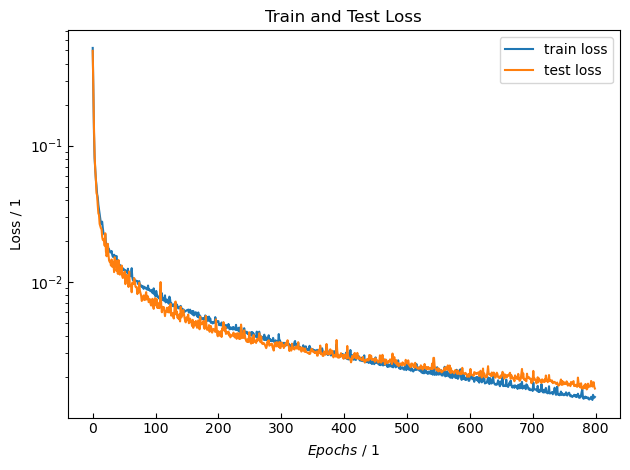

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9989335123558711 , R^2(NH3) = 0.9963480128751661
Test Dataset: R^2(H2) = 0.9983797347093353 , R^2(NH3) = 0.9972260378325253
Max Error Training: |x_H2 - x_H2,pred| = 0.032423954015862955 , |x_NH3 - x_NH3,pred| = 0.0429407800753997
Max Error Test: |x_H2 - x_H2,pred| = 0.03279442038018615 , |x_NH3 - x_NH3,pred| = 0.02870703203834074


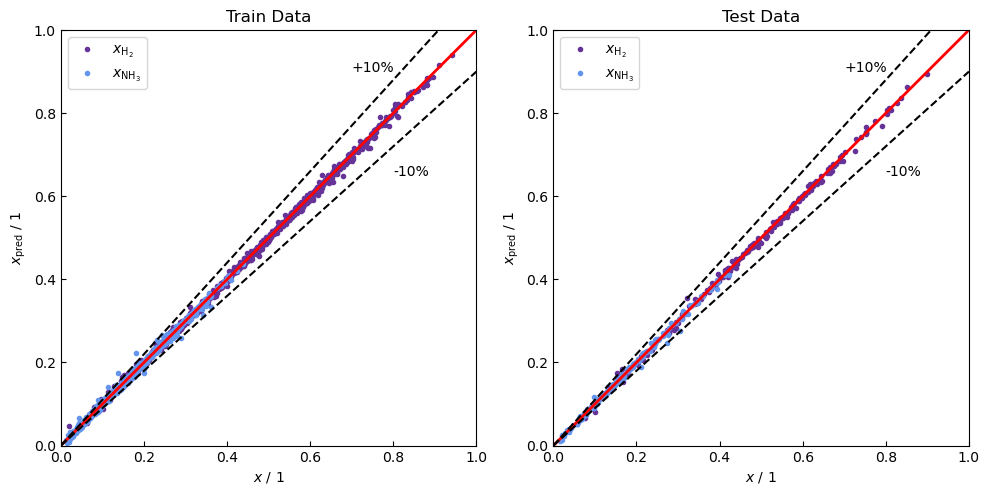

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

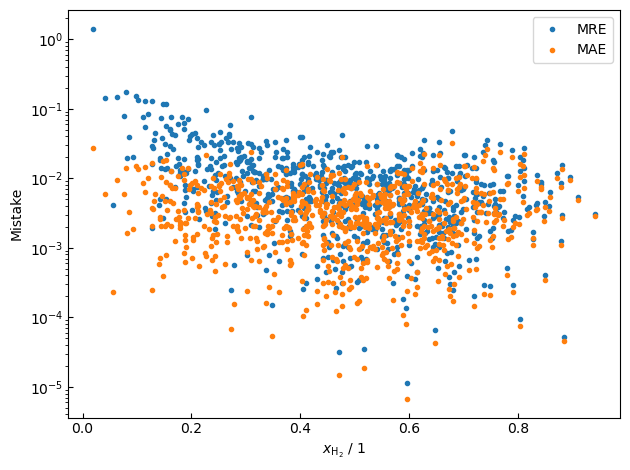

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

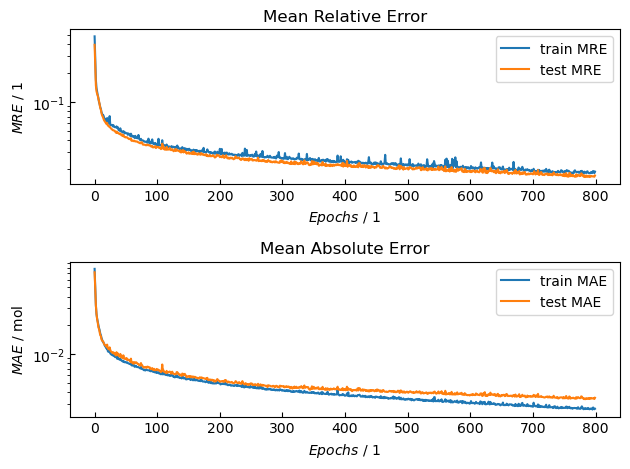

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

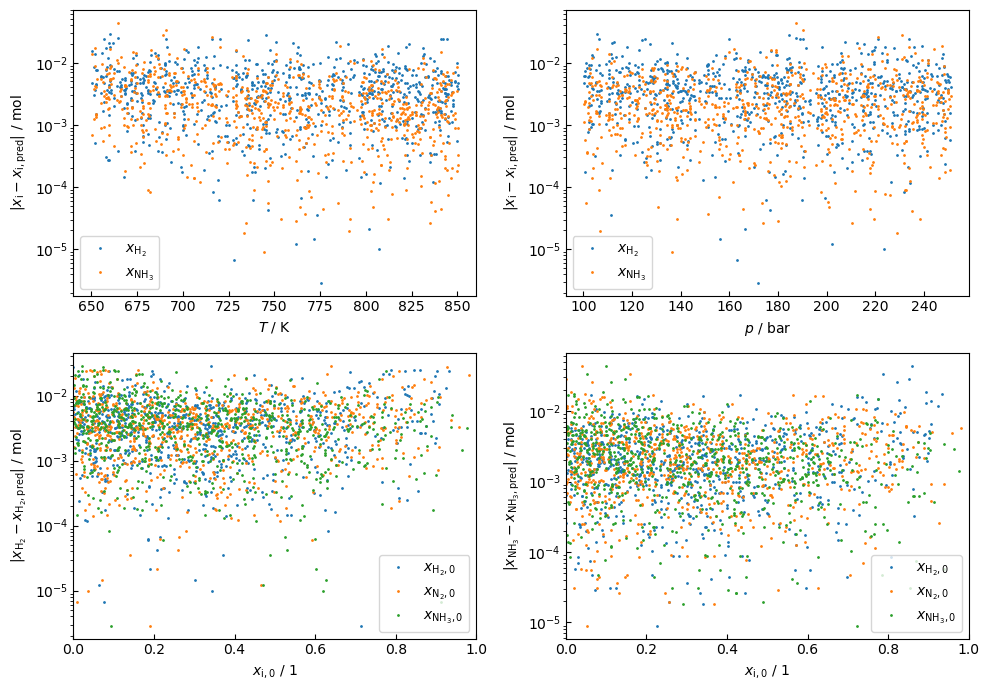

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

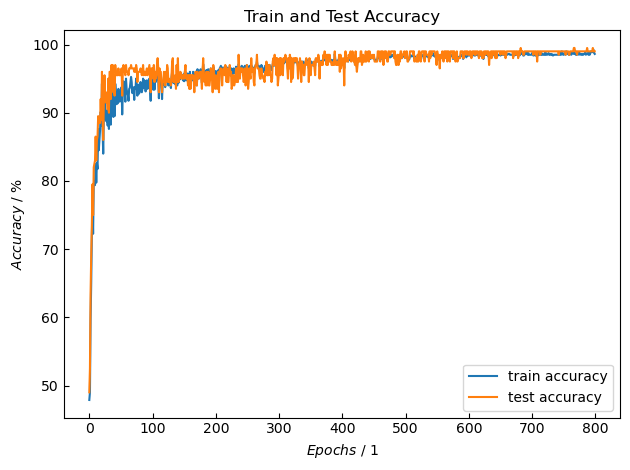

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-8.7724e-03, -9.2553e-02, -1.1977e+00,  1.3595e+00, -2.1415e-01],
        [-1.7403e+00, -2.0467e-01, -7.5283e-01, -5.4417e-01,  1.2950e+00],
        [-5.2128e-01, -4.8786e-01, -1.3674e+00,  1.5392e-01,  1.1847e+00],
        [-1.3018e+00,  7.0996e-01, -1.1304e+00,  1.7055e+00, -6.3378e-01],
        [ 1.3626e+00, -2.6209e-01,  2.2885e+00, -1.2217e+00, -9.9719e-01],
        [ 1.9927e-01, -4.2849e-01,  7.6905e-01, -3.5881e-01, -3.8800e-01],
        [ 3.2869e-01, -7.6064e-02, -1.0797e+00, -1.1995e-01,  1.1822e+00],
        [ 4.6592e-01,  1.2939e+00,  5.9378e-01, -3.3471e-01, -2.4063e-01],
        [ 6.1822e-01,  2.1092e-01,  1.7351e-01,  6.0230e-01, -7.8587e-01],
        [-4.3479e-01, -4.0794e-01,  1.9328e-01, -4.8676e-01,  3.0782e-01],
        [ 8.8061e-01,  2.2426e-01,  5.6420e-01,  8.1545e-02, -6.3704e-01],
        [ 1.1961e+00, -2.3495e-01,  1.6416e+00, -1.1335e+00, -4.5255e-01],
        [ 8.7219e-01, -1.1286e+00, -9.8994e-01, -3.3050e-01,  1.3093e+00],
        [ 6.1973e-01,  2.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.4101,  0.4069,  0.4651,  0.3751,  0.3478],
         [ 0.1877, -0.3540, -0.1653, -0.2401,  0.1353],
         [ 0.4111,  0.3832,  0.4415, -0.2945,  0.0052],
         [ 0.1784, -0.2054,  0.0898,  0.2766, -0.1636],
         [-0.1994, -0.3481,  0.3775, -0.2036,  0.3176],
         [-0.3831,  0.2200,  0.3114, -0.1245, -0.0019],
         [-0.2195,  0.0729,  0.0068,  0.4578, -0.1533],
         [-0.1014, -0.1340,  0.3654,  0.2575,  0.2740],
         [-0.3518, -0.0424,  0.0219,  0.3808, -0.0780],
         [-0.3568,  0.2838, -0.2430,  0.2571, -0.1327],
         [ 0.1916,  0.1750, -0.1133,  0.1447,  0.2070],
         [-0.0702, -0.2042, -0.4172, -0.3092,  0.0657],
         [ 0.3658, -0.1248, -0.1296, -0.3973, -0.2719],
         [-0.1998, -0.0924,  0.4062,  0.2234, -0.4018],
         [ 0.2797, -0.0919, -0.0266,  0.2136, -0.1228],
         [-0.1465,  0.0782, -0.1556, -0.3288, -0.2011],
         [ 0.3062, -0.2948,  0.2836,  0.0258,  0.2753],
         [-0.2389,  0.129

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3710, 0.1363, 0.4075, 0.0282, 0.1926],
        [0.1241, 0.7019, 0.7968, 0.7276, 0.0423]])
tensor([[ 0.3106, -0.1518],
        [-0.1850, -0.0804]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 0.5502,  1.4026, -0.6441, -0.5780,  1.2229],
        [ 0.3445, -0.0847,  1.6464, -0.5924, -1.0103],
        [ 0.9801,  0.6044, -0.8816,  1.5503, -0.7193],
        [-1.5203,  1.7218,  0.6412, -0.9911,  0.3838],
        [-1.0850,  1.4037,  0.1139,  1.0708, -1.2062],
        [ 1.5264,  1.1579, -1.1741, -1.0982,  2.2747],
        [ 1.4755, -1.5753,  2.4516, -1.0261, -1.3571],
        [ 0.8722, -1.1286, -0.9899, -0.3305,  1.3093],
        [-1.1089,  1.5590, -0.5535, -0.3270,  0.8773],
        [ 1.1987, -0.9163, -0.8983, -1.3440,  2.2553],
        [ 1.5524,  1.6091,  0.2979,  1.0719, -1.3880],
        [ 0.9721,  1.7176,  1.4535, -1.1569, -0.2441],
        [ 0.2263,  0.1655,  0.6776,  0.0701, -0.7366],
        [-0.2185,  0.1331, -0.0101,  1.1138, -1.1284],
        [-1.6555, -1.0999, -1.4309,  0.2816,  1.1165],
        [-1.3394, -1.6039,  1.2570, -0.5473, -0.6741],
        [-0.6538, -0.1485,  1.2918, -1.3779,  0.1406],
        [ 0.2265,  0.5912, -1.2603, -1.0475,  2.3074],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()